# Graphene band structure

This example plots the band structure of graphene, a 2D material. 2D band
structures are not supported natively (yet), so we manually build a custom
path in reciprocal space.

n     Energy            log10(ΔE)   log10(Δρ)   Diag
---   ---------------   ---------   ---------   ----
  1   -11.15668365602                   -0.60    5.7
  2   -11.16023105763       -2.45       -1.30    1.3
  3   -11.16040874714       -3.75       -2.32    4.1
  4   -11.16041668862       -5.10       -3.07    4.3
  5   -11.16041696519       -6.56       -3.35    5.4
Diagonalising Hamiltonian kblocks: 100%|████████████████| Time: 0:00:03


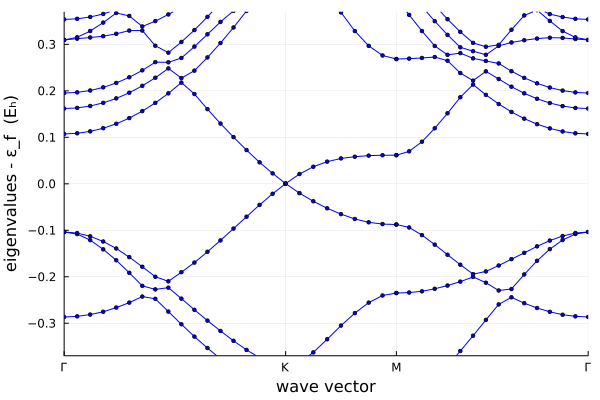

In [1]:
using DFTK
using Unitful
using UnitfulAtomic
using LinearAlgebra

# Define the convergence parameters (these should be increased in production)
L = 20  # height of the simulation box
kgrid = [6, 6, 1]
Ecut = 15
temperature = 1e-3

# Define the geometry and pseudopotential
a = 4.66  # lattice constant
a1 = a*[1/2,-sqrt(3)/2, 0]
a2 = a*[1/2, sqrt(3)/2, 0]
a3 = L*[0  , 0        , 1]
lattice = [a1 a2 a3]
C1 = [1/3,-1/3,0.0]  # in reduced coordinates
C2 = -C1
positions = [C1, C2]
C = ElementPsp(:C, psp=load_psp("hgh/pbe/c-q4"))
atoms = [C, C]

# Run SCF
model = model_PBE(lattice, atoms, positions; temperature)
basis = PlaneWaveBasis(model; Ecut, kgrid)
scfres = self_consistent_field(basis)

# Choose the points of the band diagram, in reduced coordinates (in the (b1,b2) basis)
Γ  = [0, 0, 0]
K  = [ 1, 1, 0]/3
Kp = [-1, 2, 0]/3
M  = (K + Kp)/2
kpath_coords = [Γ, K, M, Γ]
kpath_names  = ["Γ", "K", "M", "Γ"]

# Build the path manually for now
kline_density = 20
function build_path(k1, k2)
    target_Δk = 1/kline_density  # the actual Δk is |k2-k1|/npt
    npt = ceil(Int, norm(model.recip_lattice * (k2-k1)) / target_Δk)
    [k1 + t * (k2-k1) for t in range(0, 1, length=npt)]
end
kcoords = []
for i = 1:length(kpath_coords)-1
    append!(kcoords, build_path(kpath_coords[i], kpath_coords[i+1]))
end
klabels = Dict(zip(kpath_names, kpath_coords))

# Plot the bands
band_data = compute_bands(basis, kcoords; scfres.ρ)
DFTK.plot_band_data(band_data; scfres.εF, klabels)